In [1]:
MAKE_BOOK_FIGURES=Trueimport numpy as npimport scipy.stats as stimport matplotlib as mplimport matplotlib.pyplot as plt%matplotlib inlineimport matplotlib_inlinematplotlib_inline.backend_inline.set_matplotlib_formats('svg')import seaborn as snssns.set_context("paper")sns.set_style("ticks")def set_book_style():    plt.style.use('seaborn-v0_8-white')     sns.set_style("ticks")    sns.set_palette("deep")    mpl.rcParams.update({        # Font settings        'font.family': 'serif',  # For academic publishing        'font.size': 8,  # As requested, 10pt font        'axes.labelsize': 8,        'axes.titlesize': 8,        'xtick.labelsize': 7,  # Slightly smaller for better readability        'ytick.labelsize': 7,        'legend.fontsize': 7,                # Line and marker settings for consistency        'axes.linewidth': 0.5,        'grid.linewidth': 0.5,        'lines.linewidth': 1.0,        'lines.markersize': 4,                # Layout to prevent clipped labels        'figure.constrained_layout.use': True,                # Default DPI (will override when saving)        'figure.dpi': 600,        'savefig.dpi': 600,                # Despine - remove top and right spines        'axes.spines.top': False,        'axes.spines.right': False,                # Remove legend frame        'legend.frameon': False,                # Additional trim settings        'figure.autolayout': True,  # Alternative to constrained_layout        'savefig.bbox': 'tight',    # Trim when saving        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off    })def set_notebook_style():    plt.style.use('seaborn-v0_8-white')    sns.set_style("ticks")    sns.set_palette("deep")    mpl.rcParams.update({        # Font settings - using default sizes        'font.family': 'serif',        'axes.labelsize': 10,        'axes.titlesize': 10,        'xtick.labelsize': 9,        'ytick.labelsize': 9,        'legend.fontsize': 9,                # Line and marker settings        'axes.linewidth': 0.5,        'grid.linewidth': 0.5,        'lines.linewidth': 1.0,        'lines.markersize': 4,                # Layout settings        'figure.constrained_layout.use': True,                # Remove only top and right spines        'axes.spines.top': False,        'axes.spines.right': False,                # Remove legend frame        'legend.frameon': False,                # Additional settings        'figure.autolayout': True,        'savefig.bbox': 'tight',        'savefig.pad_inches': 0.1    })def save_for_book(fig, filename, is_vector=True, **kwargs):    """    Save a figure with book-optimized settings.        Parameters:    -----------    fig : matplotlib figure        The figure to save    filename : str        Filename without extension    is_vector : bool        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.    **kwargs : dict        Additional kwargs to pass to savefig    """        # Set appropriate DPI and format based on figure type    if is_vector:        dpi = 1000        ext = '.pdf'    else:        dpi = 600        ext = '.tif'        # Save the figure with book settings    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)def make_full_width_fig():    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)def make_half_width_fig():    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)if MAKE_BOOK_FIGURES:    set_book_style()else:    set_notebook_style()make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

In [ ]:
!pip install gpytorch

# Expected Improvement

We develop intuition about the expected improvement, the most popular acquisition function for Bayesian optimization.
Let's reintroduce the same running example as the previous hands-on activity.

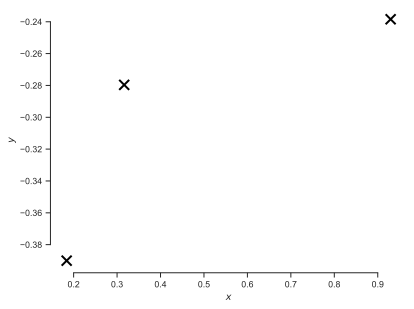

In [2]:
def f(x):
    """A function to optimize."""
    return -4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')
sns.despine(trim=True);

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression, resulting in the point-predictive distribution:

$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$

where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


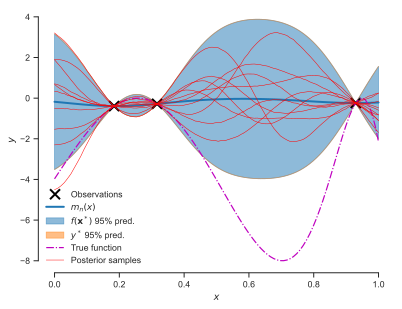

In [3]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.0
model.eval()

x = torch.linspace(0, 1, 100)
plot_1d_regression(
    x,
    model,
    f_true=f
);

The expected improvement is more involved, but it serves as a template for deriving more general information acquisition functions.
Here is how you think.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best-observed point $y_n^*$?
It is:

$$
I_n(\mathbf{x}, y) =
\begin{cases}
0,&\;\text{if}\;y \le y_n^*,\\
y - y_n^*,&\;\text{otherwise}.
\end{cases}
$$

But you don't know what $y$ is. What do you do now?
Well, the only legitimate thing to do is to take the expectation over what you expected $y$ to be given what you know.
So it is:

$$
\begin{align}
\operatorname{EI}_n(\mathbf{x}) &=& 
\int_{-\infty}^\infty I_n(\mathbf{x}, y)p(y|\mathbf{x}, \mathcal{D}_n)dy\\
&=& \int_{-\infty}^{y_n^*}0\cdot p(y|\mathbf{x}, \mathcal{D}_n)dy
+ \int_{y_n^*}^{\infty}(y - y_n^*)\cdot p(y|\mathbf{x}, \mathcal{D}_n)dy.
\end{align}
$$

You can work this out analytically.
You will get:

$$
\operatorname{EI}_n(\mathbf{x}) = \left(m_n(\mathbf{x}) - y_n^*\right)\Phi\left(\frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\right)
+ \sigma_n(x)\phi\left(\frac{m_n(\mathbf{x}) - y_n^*}{\sigma_n(\mathbf{x})}\right).
$$

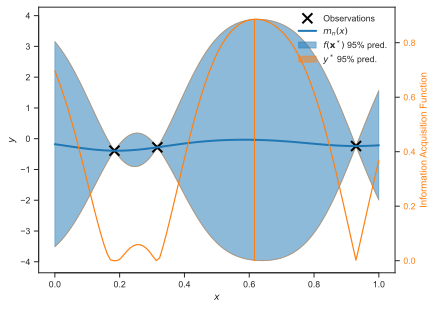

In [4]:
def ei(m, sigma, ymax):
    """Return the expected improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    diff = m - ymax
    u = diff / sigma
    ei = ( diff * torch.distributions.Normal(0, 1).cdf(u) + 
          sigma * torch.distributions.Normal(0, 1).log_prob(u).exp()
    )
    ei[sigma <= 0.] = 0.
    return ei

plot_iaf(
    x,
    model,
    ei
)

## Bayesian global optimization with the expected improvement

Let's now run the Bayesian global optimization algorithm using the expected improvement as the information acquisition function:

/Users/ibilion/.pyenv/versions/3.11.6/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


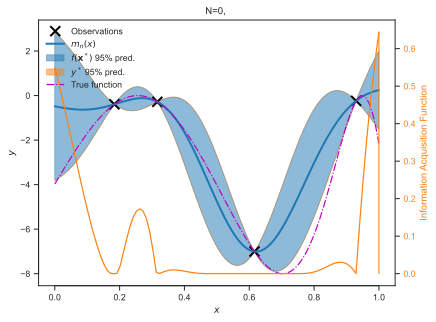

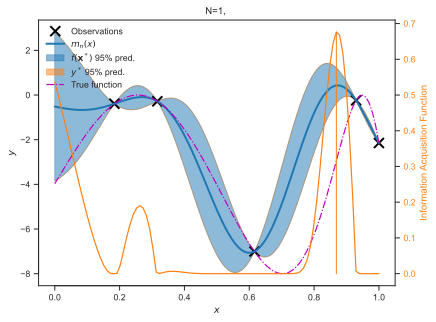

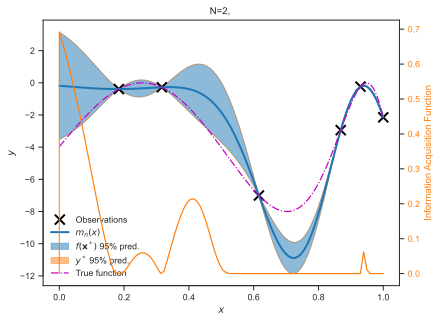

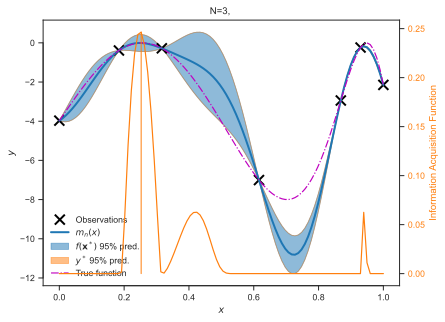

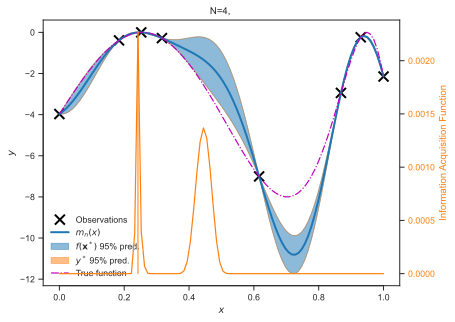

In [5]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y)

# It is not a good idea to train the model when we don't have enough data
# So we fix the hyperparameters to something reasonable
model.covar_module.base_kernel.lengthscale = 0.15
model.covar_module.outputscale = 4.0
model.likelihood.noise = 0.0
model.eval()

# Run the algorithm
X_design = torch.linspace(0, 1, 100)
af_all = maximize(
    f,
    model,
    X_design,
    ei,
    max_it=5,
    plot=1
)

### Questions

+ Rerun the main algorithm for EI by optimizing the hyper-parameters. Hint: Go through the code of ``maximize``.